In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install prophet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import optuna

In [4]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VIC.csv')
# Chuyển đổi cột thời gian thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Tạo DataFrame dữ liệu đầu vào
df = pd.DataFrame({'ds': data['Date'], 'y': data['Price']})
df

,ds,y
0,2017-12-01,61653
1,2017-12-04,62893
2,2017-12-05,60331
3,2017-12-06,60331
4,2017-12-07,59504
...,...,...
1371,2023-06-05,52100
1372,2023-06-06,53200
1373,2023-06-07,52800
1374,2023-06-08,52400


In [5]:
# Chia tập dữ liệu thành train-test-validate theo tỉ lệ
n = len(df)
n_train = int(n * 0.5)
n_test = int(n * 0.3)
n_validate = n - n_train - n_test

train_data = df[:n_train]
test_data = df[n_train:n_train + n_test]
validate_data = df[n_train + n_test:]

In [6]:
# Hàm mục tiêu để tối ưu hóa
def objective(trial):
    # Xác định không gian tìm kiếm cho siêu tham số
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 1.0),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0),
    }

    # Xây dựng mô hình BSTS với siêu tham số hiện tại
    model = Prophet(**params)
    model.fit(train_data)

    # Dự đoán trên tập test
    forecast = model.predict(test_data)

    # Tính toán độ đo RMSE để đánh giá mô hình
    rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)

    return rmse

In [7]:
# Tìm giá trị tối ưu cho siêu tham số
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=350)

# Lấy giá trị tối ưu cho siêu tham số
best_params = study.best_params

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] done processing
[I 2023-06-19 11:37:57,605] Trial 55 finished with value: 46050.551011442985 and parameters: {'changepoint_prior_scale': 0.2564999651504111, 'seasonality_prior_scale': 0.2508739328602905, 'holidays_prior_scale': 0.6440989588281911}. Best is trial 38 with value: 38903.4555096969.
<ipython-input-6-bb80d6b1eb20>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
<ipython-input-6-bb80d6b1eb20>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'seasonality_prior_scale': trial.suggest_loguniform('s

In [8]:
# Xây dựng mô hình BSTS với siêu tham số tốt nhất
best_model = Prophet(**best_params)
best_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8uyxuqbh/sc6jf7wt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8uyxuqbh/q02myda_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34006', 'data', 'file=/tmp/tmp8uyxuqbh/sc6jf7wt.json', 'init=/tmp/tmp8uyxuqbh/q02myda_.json', 'output', 'file=/tmp/tmp8uyxuqbh/prophet_modelnh17j0zb/prophet_model-20230619114312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
print("Siêu tham số tối ưu:", best_params)

Siêu tham số tối ưu: {'changepoint_prior_scale': 0.4353547483365413, 'seasonality_prior_scale': 0.18591952080857288, 'holidays_prior_scale': 0.1954425033003938}


In [10]:
# Dự đoán trên tập test và validate
test_forecast = best_model.predict(test_data)
validate_forecast = best_model.predict(validate_data)

In [11]:
# Dự đoán 30 ngày tiếp theo
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

future_forecast = best_model.predict(future_data)

In [12]:
# In kết quả dự đoán
future_forecast['yhat']

0     13314.499471
1     12987.402165
2     13022.795554
3     13390.084396
4     13288.565323
5     13409.663499
6     13518.973594
7     13572.872793
8     13239.658724
9     13247.296552
10    13565.802843
11    13395.659879
12    13430.006245
13    13436.617837
14    13374.449041
15    12914.689239
16    12788.421458
17    12968.913458
18    12659.937726
19    12557.868952
20    12433.575853
21    12248.879579
22    11677.536180
23    11452.831894
24    11549.823225
25    11173.619468
26    11021.457105
27    10864.583267
28    10664.720431
29    10095.069294
Name: yhat, dtype: float64

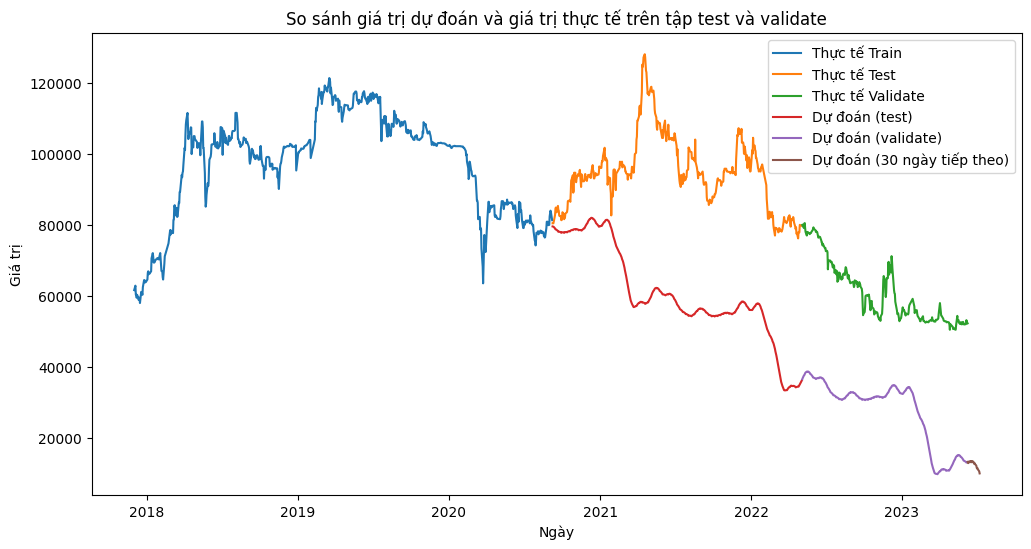

In [13]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Thực tế Train')
plt.plot(test_data['ds'], test_data['y'], label='Thực tế Test')
plt.plot(validate_data['ds'], validate_data['y'], label='Thực tế Validate')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Dự đoán (test)')
plt.plot(validate_data['ds'], validate_forecast['yhat'], label='Dự đoán (validate)')
plt.plot(future_dates, future_forecast['yhat'], label='Dự đoán (30 ngày tiếp theo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập test và validate')
plt.legend()
plt.show()

In [14]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho test data
rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
mape = mean_absolute_percentage_error(test_data['y'], test_forecast['yhat'])*100
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 37085.04453979686
MAPE: 35.35373591187751
MSE: 1375300528.5187168
MAE: 33821.524012949056
R2: -12.423082929329837


In [15]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho validate data
rmse = np.sqrt(mean_squared_error(validate_data['y'], validate_forecast['yhat']))
mape = mean_absolute_percentage_error(validate_data['y'], validate_forecast['yhat'])*100
mse = mean_squared_error(validate_data['y'], validate_forecast['yhat'])
mae = mean_absolute_error(validate_data['y'], validate_forecast['yhat'])
r2 = r2_score(validate_data['y'], validate_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 34171.468457747236
MAPE: 55.35383737286102
MSE: 1167689256.5588143
MAE: 33492.79145521367
R2: -14.235103040323814
